In [1]:
%load_ext autoreload
%autoreload 2

# Getting Started with SAFE


The SAFE encoding format is a rewriting of SMILES to ensure that any molecule can be written as a sequence of fragments where atoms or tokens corresponding to given fragments form a **substring**(ontiguous sequence) in the line notation representation. 

SAFE addresses some of the limitation of SMILES strings when it comes to *generative design*:


<table>
<tr>
    <th>SAFE</th>
    <th>Others</th>
</tr>
<tr>
<td>
<sub>

```diff
+ native support for (sub)structure-constrained design
```
</sub>

<td>

<sub>

```diff
- different generative models for different generative tasks 
- extensive substructure matching for filtering after generation
- multiple steps generative process (e.g Liao et al. 2023, 10.1093/bioinformatics/btac814)
- graph based approaches with their limitations
```

</sub>
</td>
</tr>
<tr>
<td>
<sub>

```diff
+ any molecule generation as a simple NLP task (sequence completion or mask filling)
+ a single autoregressive sequence model for both linker generation and scaffold decoration.
```
</sub>

<td>
<sub>

```diff
- complex training and decoding schemes for scaffold-constrained generation (e.g Arús-Pous et al. 2020, 10.1186/s13321-020-00441-8)
- complex sampling algorithms for scaffold-constrained generation (e.g Langevin et al. 2020, 10.1021/acs.jcim.0c01015)
```

</sub>
</td>
</tr>
<tr>
<td>
<sub>

```diff
+ SAFE strings are SMILES strings
```

</sub>
</td>

<td>
<sub>

```diff
- requires a different chemical language (e.g Krenn et al. 2022, 10.1016/j.patter.2022.100588)
```

</sub>
</td>

</tr>

</table>

## Using SAFE

In the following we will highlight how to use SAFE and some of the properties of SAFE strings.

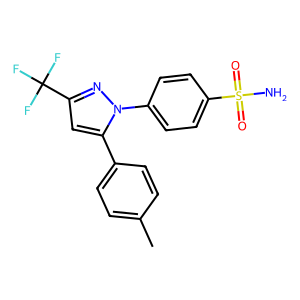

In [2]:
import safe as sf
import datamol as dm

celecoxib = "Cc1ccc(-c2cc(C(F)(F)F)nn2-c2ccc(S(N)(=O)=O)cc2)cc1"
celecoxib_mol = dm.to_mol(celecoxib)
display(dm.to_image(celecoxib_mol))

#### Encoding

!!! info "SAFE represents fragments"

    SAFE represents molecules as a set of N [Fragment_1].[Fragment_i].[Fragment_N]
    

In [3]:
safe_str = sf.encode(celecoxib_mol)
print(safe_str)
print(f"Representation using {len(safe_str.split('.'))} fragments")

c14ccc(S(N)(=O)=O)cc1.Cc1ccc3cc1.c13cc5nn14.C5(F)(F)F
Representation using 4 fragments


!!! info "SAFE string are SMILES"

    Any SAFE string is a valid SMILES and can be read by RDKit without any decoding trick.

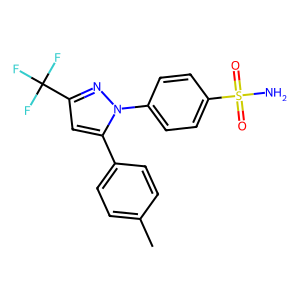

True

In [4]:
reconstructed = dm.to_mol(safe_str)
display(dm.to_image(reconstructed))
dm.same_mol(celecoxib_mol, reconstructed)

!!! info "SAFE supports randomization"

    You can generate randomized SAFE strings.

In [5]:
random_safe_str = sf.encode(celecoxib_mol, canonical=False, randomize=True)
print(random_safe_str)
reconstructed = dm.to_mol(safe_str)
dm.same_mol(celecoxib_mol, reconstructed)

C(F)(F)(F)4.c1cc(S(=O)(=O)N)ccc12.c13ccc(C)cc1.n12nc4cc13


True

!!! info "Fragment order in SAFE does not matter"

    Any permutation of the fragment order in a SAFE string preserve the molecule identity

In [6]:
import numpy as np
fragments = safe_str.split(".")
randomized_fragment_safe_str = np.random.permutation(fragments).tolist()
randomized_fragment_safe_str = ".".join(randomized_fragment_safe_str)
print(randomized_fragment_safe_str, safe_str)
dm.same_mol(celecoxib_mol, randomized_fragment_safe_str)

c14ccc(S(N)(=O)=O)cc1.c13cc5nn14.Cc1ccc3cc1.C5(F)(F)F c14ccc(S(N)(=O)=O)cc1.Cc1ccc3cc1.c13cc5nn14.C5(F)(F)F


True

!!! info "Use your own slicing logic"
    
    By default SAFE strings are generated using `BRICS`, however, the following are supported:
    * [Hussain-Rea (`hr`)](https://pubs.acs.org/doi/10.1021/ci900450m)
    * [RECAP (`recap`)](https://pubmed.ncbi.nlm.nih.gov/9611787/)
    * [RDKit's MMPA (`mmpa`)](https://www.rdkit.org/docs/source/rdkit.Chem.rdMMPA.html)
    * Any possible attachment points (`attach`)
        
    Furthermore, you can also provide your own slicing algorithm, which should return a pair of atoms corresponding to the bonds to break. 



C%19%20%17%24.c1%19c9c%15c%25c8c1%14.c1%25c5c%12nn1%26.C%18%217%12.F%18.F7.F%21.c1%26c%27c%22c4c%16c1%11.S=3=%1046.N%236%13.O=3.O=%10.[H]%17.[H]%24.[H]%20.[H]9.[H]%15.[H]5.[H]%27.[H]%22.[H]%13.[H]%23.[H]%16.[H]%11.[H]8.[H]%14
Representation using 26 fragments


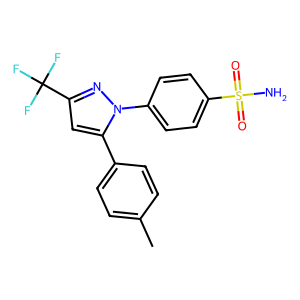

In [7]:
safe_str = sf.encode(celecoxib_mol, canonical=False, slicer="attach")
print(safe_str)
print(f"Representation using {len(safe_str.split('.'))} fragments")
display(dm.to_image(safe_str))

In [8]:
def my_slicer(mol):
    """Slice on non single bonds where at both atoms are in a distinct rings"""
    for bond in mol.GetBonds():
        if bond.GetBondType() == dm.SINGLE_BOND and not bond.IsInRing() and (bond.GetBeginAtom().IsInRing() and bond.GetEndAtom().IsInRing()):
            yield (bond.GetBeginAtomIdx(), bond.GetEndAtomIdx())

In [9]:
safe_str = sf.encode(celecoxib_mol, canonical=True, slicer=my_slicer)
print(safe_str)
print(f"Representation using {len(safe_str.split('.'))} fragments")

c14cc(C(F)(F)F)nn13.c13ccc(S(N)(=O)=O)cc1.Cc1ccc4cc1
Representation using 3 fragments


In [10]:
# The above is equivalent to using the following SMARTS:
smart_slicer = ["[r]-;!@[r]"]
safe_str = sf.encode(celecoxib_mol, canonical=True, slicer=smart_slicer)
print(safe_str)
print(f"Representation using {len(safe_str.split('.'))} fragments")

c13cc(C(F)(F)F)nn14.c14ccc(S(N)(=O)=O)cc1.Cc1ccc3cc1
Representation using 3 fragments


#### Decoding

!!! info "Fragment order in SAFE does not matter"

    Each `SAFE fragment` is a valid molecule itself, however, you need to use the decoder to recover molecules where all attachment point are not fullfiled.

In [11]:
safe_fragment = safe_str.split(".")
safe_fragment

['c13cc(C(F)(F)F)nn14', 'c14ccc(S(N)(=O)=O)cc1', 'Cc1ccc3cc1']

In [12]:
# the following will fail
dm.to_mol(safe_fragment[0])

[14:10:13] SMILES Parse Error: unclosed ring for input: 'c13cc(C(F)(F)F)nn14'


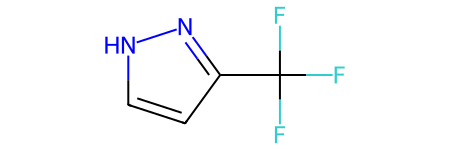

In [13]:
# while this works
sf.decode(safe_fragment[0], as_mol=True)

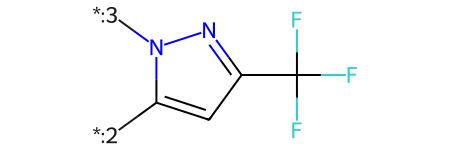

In [14]:
# if you want to keep the attachment points, then use remove_dummies=False
sf.decode(safe_fragment[0], as_mol=True, remove_dummies=False)

### Displaying a SAFE encoding

We provide a visualization module to display a safe string, with highlight of all the fragments that compose it.


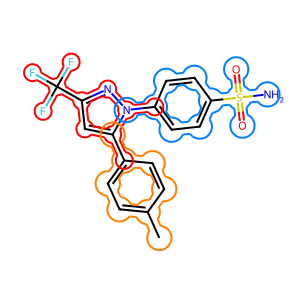

In [15]:
sf.to_image(safe_str)

There are 3 display modes for highlighting the fragments in a SAFE string. The difference between those modes is highlighted below using two different slicing algorithm. 

!!! danger "Overlapping fragments"
    Note that because some fragment might be matching overlapping substructure of the molecules (for example the same fragment appearing multiple time in the molecule), the highlighting might assigned the same color to these fragments.

In [16]:

from IPython.display import display
from ipywidgets import widgets, HBox

def display_image(safe_str):
    image_lasso = widgets.Image(value=sf.to_image(safe_str, highlight_mode="lasso", legend="lasso mode").data.encode(), format='svg+xml')
    image_fill = widgets.Image(value=sf.to_image(safe_str, highlight_mode="fill", legend="fill mode").data.encode(), format='svg+xml')
    image_color = widgets.Image(value=sf.to_image(safe_str, highlight_mode="color", legend="color mode").data.encode(), format='svg+xml')
    hbox = HBox([image_lasso, image_fill, image_color])
    display(hbox)

In [17]:
# display for brics
safe_str_brics = sf.encode(celecoxib_mol, canonical=True, slicer="brics")
display_image(safe_str_brics)

In [18]:
# display with HR
safe_str_hr = sf.encode(celecoxib_mol, canonical=True, slicer="mmpa")
display_image(safe_str_hr)

## Understanding SAFE

The intuition behind safe is quite simple: we want to represent any molecule as a  `set of connected fragments`.

### Preliminary on SMILES.

Let's start first by revisiting some information about the SMILES syntax:

- **An asterisk `*` in a smiles is usually employed to indicate any atom OR an attachment point of any group. It's particularly useful for smarts matching.**

- **Number in smiles syntax indicates connectivity points between two atoms. For 2 digits numbers they would need to be preceeded by `%`**. 

This is partially explained on the wikipedia [ring section of SMILES](https://en.wikipedia.org/wiki/Simplified_molecular-input_line-entry_system#Rings).

- **A dot `.` in smiles indicates the presence of additional fragments and is used to separate them**. 

A good ressource on the subject is the [DAYLIGHT page](https://www.daylight.com/dayhtml/doc/theory/theory.smiles.html).

We illustrate these informations below !

In [19]:
import datamol as dm
import safe as sf
from rdkit import Chem
from rdkit.Chem.Draw import rdDepictor
from rdkit.Chem import rdChemReactions as rdr
rdDepictor.SetPreferCoordGen(True)

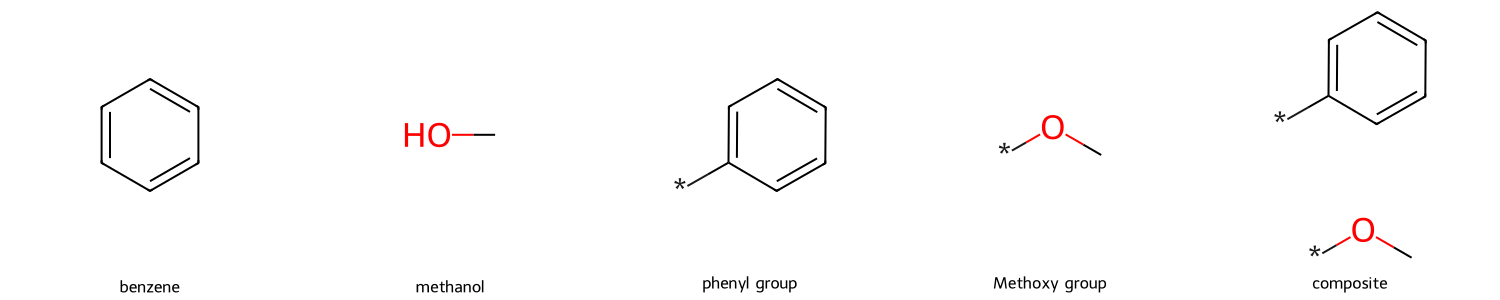

In [20]:
smiles = ['c1ccccc1', 'OC', 'c1cc(*)ccc1', 'O(*)C', 'c1cc(*)ccc1.O(*)C']
legends = ['benzene', 'methanol', 'phenyl group', 'Methoxy group', 'composite']
dm.viz.to_image([dm.to_mol(x) for x in smiles], legends=legends, n_cols=len(smiles), use_svg=True)

In the example above, we can see that `phenol` can be represented as two fragments that can be connected given proper attachment point. 

To achieve this we are interested in attaching 2 fragments together (the `methoxy` and the `phenyl` groups). In RDKit, this can usually be achieved using chemical reactions. For convenience, we will prefer a standardized representation of attachment points that includes an atom mapping.

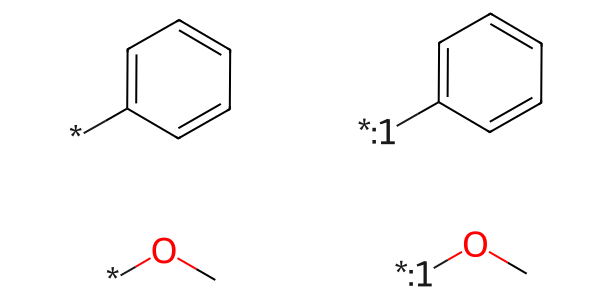

In [21]:
smiles = [ 'c1cc(*)ccc1.O(*)C', 'c1cc([*:1])ccc1.O([*:1])C'] #
dm.viz.to_image([dm.to_mol(x) for x in smiles], n_cols=len(smiles), use_svg=True)

To attach the two fragments, I can write a simple chemical transformation. Since smarts and smiles syntax do not mix very well when it comes to `*` I will assume an isotopic representation `[1*]` instead of `[*:1]`


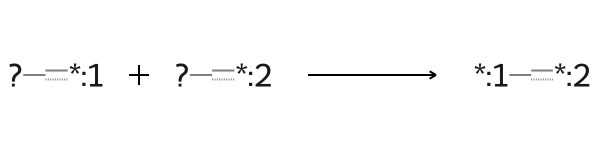

In [22]:
rxn = rdr.ReactionFromSmarts("[1*][*:1].[1*][*:2]>>[*:1][*:2]")
rxn

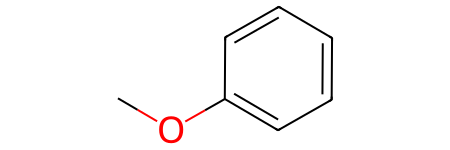

In [23]:
# replace atom map by isotopes
phenyl = "c1cc([*:1])ccc1".replace("[*:1]", "[1*]")
methoxy = "O([*:1])C".replace("[*:1]", "[1*]")

# runreactions
prod = rxn.RunReactants((dm.to_mol(phenyl), dm.to_mol(methoxy)))
prod[0][0]

We can achieve the same result by using rdkit API in an slightly more tedious way.


[14:10:33] WARNING: not removing hydrogen atom without neighbors


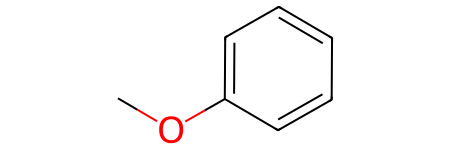

In [24]:
replacement_sub =  Chem.MolFromSmarts("[1*]")
prod = Chem.ReplaceSubstructs(dm.to_mol(phenyl), replacement_sub, dm.to_mol(methoxy), replacementConnectionPoint=0)
prod = dm.remove_dummies(prod[0], dummy="[1*]")
prod

But wait, could we attach the fragment using only the string operations on the smiles ?

Well, it's not possible by trying to perform substring replacement, but recall we just said that `numbers in smiles represents connectivity points` ?

In [25]:
phenyl = "c1cc([*:1])ccc1"
methoxy = "O([*:1])C"
composite = phenyl + "." + methoxy # c1cc([*:1])ccc1.O([*:1])C
compo = dm.to_mol(composite)

Since `1` "connectivity point" is already present in the phenyl group. We need to start by opening a new connectivity point: `2`

In [26]:
attached_composite = composite.replace("[*:1]", "2")
dm.to_mol(attached_composite)

[14:10:35] SMILES Parse Error: syntax error while parsing: c1cc(2)ccc1.O(2)C
[14:10:35] SMILES Parse Error: Failed parsing SMILES 'c1cc(2)ccc1.O(2)C' for input: 'c1cc(2)ccc1.O(2)C'


The previous line does not work because of violation in the smiles syntax. As we are not taking into account the branching bracket surrounding the attachment point.

We could try to regenerate the smiles or scan the sequence and remove the brackets when it's possible, but we want to limit the operations to `str.replace`. So let's try again.

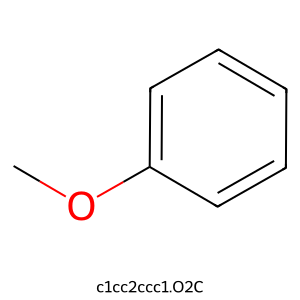

In [27]:
attached_composite = composite.replace("([*:1])", "2").replace("[*:1]", "2")
dm.to_image(attached_composite, legends=[attached_composite])


You can see that the phenol molecule is represented as two "fragments" `[Fragment1].[Fragment2]`. That is what SAFE is about.

In summary, to build a SAFE string, we just need to follow the step below:

![safe](../assets/safe-construction.svg)